In [1]:
# check the cars that have a disabled parking permit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#import sys
#sys.path.append('/Users/dpelleg/miniconda/lib/python3.10/site-packages')

from statsmodels.stats.proportion import proportions_ztest

# do I need this? how to persist the change in path?


In [10]:
datadir = '../data/apr2023/'

def count_repeated_chars(string, k):
    count = 0
    for i in range(len(string)-(k-1)):
        if string[i:i+k] == string[i]*k:
            count += 1
    return count

def is_palindrome(string):
    return string == string[::-1]

def has_numeric_sequence_3(string):
    for i in range(len(string)-2):
        if int(string[i])+1 == int(string[i+1]) and int(string[i+1])+1 == int(string[i+2]):
            return True
    return False

def has_numeric_sequence_3_rev(string):
    return has_numeric_sequence_3(string[::-1])

def count_distinct_chars(string):
    return len(set(string))

def distinct_chars_under(s, n):
    return count_distinct_chars(s) <= n

def distinct_chars_over(s, n):
    return count_distinct_chars(s) >= n

def count_repeated_sequences(string, seq_length):
    count = 0
    for i in range(len(string) - seq_length + 1):
        if string[i:i+seq_length] in string[i+seq_length:]:
            count += 1
    return count

scoremap = {
    lambda s: count_repeated_chars(s, 2): 1,
    lambda s: count_repeated_chars(s, 3): 1,
    lambda s: count_repeated_chars(s, 4): 1,
    is_palindrome: 5,
    has_numeric_sequence_3 : 2,
    has_numeric_sequence_3_rev : 2,
    lambda s: distinct_chars_under(s, 1): 10,
    lambda s: distinct_chars_under(s, 2): 5,
    lambda s: distinct_chars_under(s, 3): 2,
#    lambda s: distinct_chars_over(s, 5): 2,
#    lambda s: distinct_chars_over(s, 6): 5,
#    lambda s: distinct_chars_over(s, 7): 6,
#    lambda s: distinct_chars_over(s, 8): 8,
    lambda s: count_repeated_sequences(s, 2): 2,
    lambda s: count_repeated_sequences(s, 3): 3,
}

def score(s):
    ret = 0
    for idx, (f, mult) in enumerate(scoremap.items()):
        result = f(s)
        ret += mult*int(result)
    return ret

In [11]:
def read_file(fname, enc='iso8859-8'):
    fd = open(fname, encoding=enc, errors='replace')
    df = pd.read_csv(fd, sep='|')
    return df

def add_model(df):
    df['model'] = df.apply(lambda x: '_'.join([x[y] for y in ['tozeret_cd', 'degem_cd', 'shnat_yitzur', 'sug_degem']]), axis=1)

def get_model_name(ns):
    names = pd.DataFrame(data={'model':ns})
    ret = pd.merge(names, models, how='left', on='model')[['tozeret_nm', 'kinuy_mishari']]
    return ret

def ztest_proportions(df, population, test):
    xtab=pd.crosstab(df[population], df[test])
    se, pval = proportions_ztest(xtab[True].to_list(), xtab.sum(axis=1).to_list())
    return pval

In [12]:
# source : https://data.gov.il/dataset/private-and-commercial-vehicles/
#   (if it doesn't download fully, try with Chrome)

#df = pd.read_csv('data/rechev-small.csv', encoding='iso-8859-1', sep='|')
cars = read_file(datadir + 'rechev.csv')

for c in ['mispar_rechev', 'degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    cars[c] = cars[c].astype(str)

add_model(cars)

cars['score'] = cars['mispar_rechev'].apply(score)

In [13]:
# source: https://data.gov.il/dataset/rechev-tag-nachim
disabled = pd.read_csv(datadir + 'disabled-plates.csv', sep='|')
disabled.columns = ['mispar_rechev', 'taarich_tag', 'sug_tag']
for c in ['mispar_rechev']:
    disabled[c] = disabled[c].astype(str)
#disabled['score'] = disabled['mispar_rechev'].apply(score)

In [14]:
# merge dataframes
merged = pd.merge(cars, disabled, on='mispar_rechev', how='left', indicator=True)

# create boolean column indicating if record exists in Y
merged['disabled'] = merged['_merge'] == 'both'
merged.drop(columns=['_merge'], inplace=True)
# there are about 14,000 records which are only in the disabled set, not much to do about them

df = merged

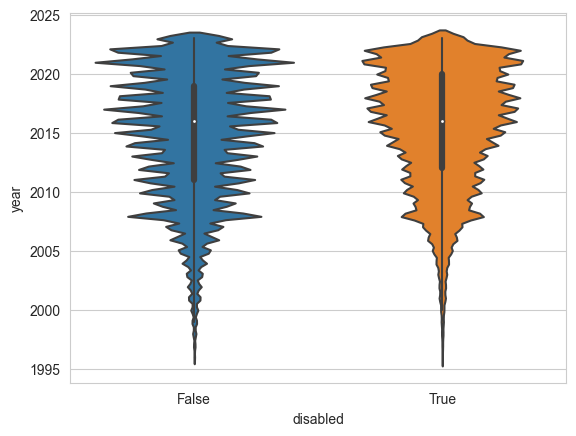

In [15]:
df['year'] = pd.to_numeric(df['shnat_yitzur'], errors='ignore')
sns.violinplot(x='disabled', y='year', data=df)

plt.show()

In [16]:
# source : https://data.gov.il/dataset/mehir_yevuan
# add model prices
fname = datadir + 'vehicle_cost.csv'
fd = open(fname, encoding='utf-8', errors='replace')
prices = pd.read_csv(fd, sep='|', low_memory=False)

for c in ['degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    prices[c] = prices[c].astype(str)
for c in ['mehir']:
    prices[c] = pd.to_numeric(prices[c], errors='coerce')

add_model(prices)
prices_ = prices.copy()
prices = prices[['model', 'mehir']]
df = pd.merge(left=df, right=prices, on='model')

In [17]:
cols =['ramat_eivzur_betihuty', 'kvutzat_zihum', 'score', 'year', 'mehir']
df.groupby('disabled')[cols].agg(['mean', 'count'])

ramat_eivzur_betihuty          kvutzat_zihum              score  \
                          mean    count          mean    count      mean   
disabled                                                                   
False                 3.159689  1147598     12.111586  2775049  1.097310   
True                  3.238399   209099     12.233606   460130  1.141072   

                          year                   mehir           
            count         mean    count           mean    count  
disabled                                                         
False     3126296  2014.994790  3126296  149823.249919  3126296  
True       504729  2015.613523   504729  159892.038975   504729

In [18]:
#sns.violinplot(x='disabled', y='mehir', data=df.query('mehir < 4e5'))
#plt.show()

In [19]:
# read detailed tech specs on each model
# source: https://data.gov.il/dataset/degem-rechev-wltp
models = read_file(datadir + 'models.csv', enc='utf-8')
#models.columns
cols = ['tozeret_cd', 'tozeret_nm', 'shnat_yitzur',
       'degem_cd', 'nefah_manoa',
       'mishkal_kolel', 'gova',
       'hege_koah_ind',
       'automatic_ind',
       'koah_sus',
       'mispar_moshavim', 'kinuy_mishari', 'sug_degem',
       'hanaa_nm', 'merkav'
       ]
models = models[cols]
for c in ['degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    models[c] = models[c].astype(str)

add_model(models)
df_before = df.copy()
merged = pd.merge(left=df_before, right=models.drop(columns=['kinuy_mishari', 'sug_degem', 'tozeret_nm']), on='model', how='left', indicator=True)
merged.drop(columns=['_merge'], inplace=True)
df=merged

/var/folders/l5/kkx8dwdn57s3v0k59p9m7sv80007gv/T/ipykernel_22615/907659671.py:3: DtypeWarning: Columns (16,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fd, sep='|')
/var/folders/l5/kkx8dwdn57s3v0k59p9m7sv80007gv/T/ipykernel_22615/2327500883.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  models[c] = models[c].astype(str)
/var/folders/l5/kkx8dwdn57s3v0k59p9m7sv80007gv/T/ipykernel_22615/907659671.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['m

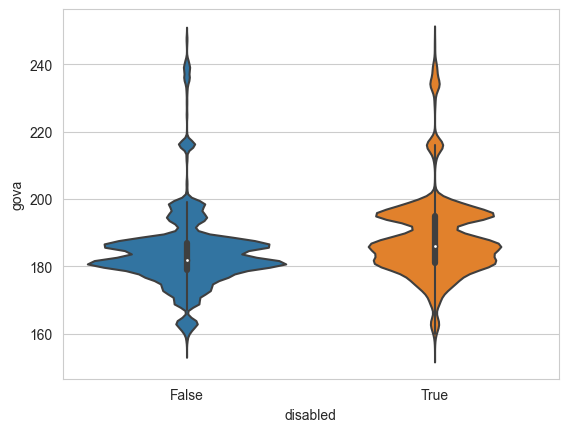

In [20]:
sns.violinplot(x='disabled', y='gova', data=merged.query('gova > 150 and gova < 250'))
#plt.legend(title="הכנ", labels=["No", "Yes"])
plt.show()

In [21]:
df['mehir'].quantile(0.9)

219024.0

In [22]:
df['koah_sus'].quantile(0.95)

204.0

In [25]:
# check proportions of news cars with disabled permits
df['new'] = df['year'] > 2020
df['newest'] = df['year'] > 2022

# check proportions of luxury cars with disabled permits
df['luxury'] = df['mehir'] > df['mehir'].quantile(0.9)

# check proportions of fancy-plate cars with disabled permits
df['coolnum'] = df['score'] > df['score'].quantile(0.9)

# check proportions of tall cars with disabled permits
df['tall'] = df['gova'] > 220

# check proportions of short cars with disabled permits
df['short'] = (df['gova'] < 160) & (df['gova'] > 0)

# check proportions of muscle cars with disabled permits
df['muscle'] = df['koah_sus'] > df['koah_sus'].quantile(0.95)

# Tesla
df['tesla'] = df['tozeret_nm'].str.contains("טסלה")

# people-mover
df['seven'] = df['mispar_moshavim'] >= 7

# huge pickup type
df.loc[:, 'monster'] = df.eval('gova > 180 and hanaa_nm == "4X4" and nefah_manoa > 2000 and mispar_moshavim < 7')

# chassis type fits a people-mover
mask_merkavim = ["סגור/משלוח", "משא אחוד", "ואן/נוסעים", "קומבי"]
mask_merkavim.append("MPV")
df['ppl_mover'] = df['merkav'].isin(mask_merkavim)


# more features
features = ['automatic_ind', 'hege_koah_ind']
for c in features:
    df[c] = df[c] == 1

features = ['new', 'newest', 'luxury', 'coolnum', 'tall', 'short', 'muscle', 'tesla', 'seven', 'monster', 'ppl_mover'] + features
for f in features:
    pv = ztest_proportions(df, 'disabled', f)
    print(f'Testing {f}, p-val:{pv:.3f}')
    print(pd.crosstab(df['disabled'], df[f], normalize='index'))
    print(pd.crosstab(df['disabled'], df[f]))
    print('-----')

Testing new, p-val:0.000
new          False     True 
disabled                    
False     0.816409  0.183591
True      0.806688  0.193312
new         False   True 
disabled                 
False     2552335  573961
True       407159   97570
-----
Testing newest, p-val:0.000
newest       False     True 
disabled                    
False     0.969912  0.030088
True      0.976249  0.023751
newest      False  True 
disabled                
False     3032233  94063
True       492741  11988
-----
Testing luxury, p-val:0.000
luxury       False     True 
disabled                    
False     0.903374  0.096626
True      0.879099  0.120901
luxury      False   True 
disabled                 
False     2824216  302080
True       443707   61022
-----
Testing coolnum, p-val:0.000
coolnum      False     True 
disabled                    
False     0.953556  0.046444
True      0.948372  0.051628
coolnum     False   True 
disabled                 
False     2981097  145199
True       478671   26

In [26]:
for f in features:
    print('example of cars of type:' + f)
    ns=list(df.query(f)['model'].value_counts().index[:20])
    print(get_model_name(ns).drop_duplicates())

example of cars of type:new
        tozeret_nm    kinuy_mishari
0    יונדאי קוריאה     IONIQ HYBRID
1       קיה קוריאה          PICANTO
2    טויוטה טורקיה  COROLLA HSD SDN
3      מזדה תאילנד          MAZDA 2
4          מ.ג סין         EHS PHEV
8    יונדאי טורקיה              I20
9         גילי סין       GEOMETRY C
10   יונדאי קוריאה      ELANTRA HEV
11      רנו טורקיה           MEGANE
12       בי ווי די           ATTO 3
14     טויוטה צרפת  YARIS CROSS HSD
15      קיה קוריאה           SELTOS
16      קיה קוריאה        NIRO PHEV
17       סיאט ספרד            ARONA
18  מיצובישי תאילנ       SPACE STAR
19   טויוטה טורקיה      C-HR HYBRID
example of cars of type:newest
       tozeret_nm    kinuy_mishari
0       בי ווי די           ATTO 3
1     מזדה תאילנד          MAZDA 2
2        גילי סין       GEOMETRY C
3        צ'רי סין      TIGGO 8 PRO
4   יונדאי קוריאה      ELANTRA HEV
6      קיה קוריאה   NIRO PLUS PHEV
7      קיה קוריאה          PICANTO
8     טויוטה צרפת  YARIS CROSS HSD
9         מ.ג 

In [27]:
for f in ['muscle', 'seven']:
    for b in ['', ' not ']:
        fb = f'{f} and {b} disabled'
        print('example of cars of type:' + fb)
        ns=list(df.query(fb)['model'].value_counts().index[:10])
        print(get_model_name(ns).drop_duplicates())

example of cars of type:muscle and  disabled
      tozeret_nm   kinuy_mishari
0  יונדאי קוריאה          IONIQ5
1     קיה קוריאה        CARNIVAL
3     ג'יפ ארהב"  GRAND CHEROKEE
4    ביואיק ארהב        LACROSSE
6   שברולט ארהב"       MALIBU LT
7       טסלה סין         MODEL 3
example of cars of type:muscle and  not  disabled
      tozeret_nm   kinuy_mishari
0       טסלה סין         MODEL 3
1  יונדאי קוריאה          IONIQ5
5     קיה קוריאה        CARNIVAL
6    ביואיק ארהב        LACROSSE
7     ג'יפ ארהב"  GRAND CHEROKEE
8   שברולט ארהב"       MALIBU LT
example of cars of type:seven and  disabled
     tozeret_nm kinuy_mishari
0  מיצובישי יפן     OUTLANDER
3  מיצובישי יפן       GRANDIS
5      מזדה יפן       MAZDA 5
9   סקודה צ'כיה        KODIAQ
example of cars of type:seven and  not  disabled
     tozeret_nm kinuy_mishari
0  מיצובישי יפן     OUTLANDER
1      צ'רי סין   TIGGO 8 PRO
4      מזדה יפן       MAZDA 5
5  מיצובישי יפן       GRANDIS


In [28]:
# check if vans are more likely to be new-ish
# the social security funds replacement of vans every 5 years for the disabled
df['year'] = df['shnat_yitzur_x'].astype(int)
pm = df.query('ppl_mover')
pm.loc[:, 'new'] = pm['year'] > 2018

for f in ['new', 'tall']:
    pv = ztest_proportions(pm, 'disabled', f)
    print(f'Testing {f}, p-val:{pv:.3f}')
    print(pd.crosstab(pm['disabled'], pm[f], normalize='index'))
    print(pd.crosstab(pm['disabled'], pm[f]))
    print('-----')

Testing new, p-val:0.000
new          False     True 
disabled                    
False     0.735020  0.264980
True      0.620736  0.379264
new        False  True 
disabled               
False     123526  44532
True       19290  11786
-----
Testing tall, p-val:0.000
tall         False     True 
disabled                    
False     0.977305  0.022695
True      0.981980  0.018020
tall       False  True 
disabled               
False     164244   3814
True       30516    560
-----


/var/folders/l5/kkx8dwdn57s3v0k59p9m7sv80007gv/T/ipykernel_22615/3931476907.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm.loc[:, 'new'] = pm['year'] > 2018


In [29]:
ns=list(df.query('muscle and disabled')['model'].value_counts().index[:20])
print(get_model_name(ns).drop_duplicates())

       tozeret_nm   kinuy_mishari
0   יונדאי קוריאה          IONIQ5
1      קיה קוריאה        CARNIVAL
3      ג'יפ ארהב"  GRAND CHEROKEE
4     ביואיק ארהב        LACROSSE
6    שברולט ארהב"       MALIBU LT
7        טסלה סין         MODEL 3
10    שברולט קנדה      IMPALA LTZ
11  קאדילאק ארהב"             XT5
15  קאדילאק ארהב"             XT4
17    סקודה צ'כיה      NEW SUPERB
18   קרייזלר קנדה        PACIFICA


In [30]:
print(df['mehir'].median())
C='model'
value_counts = df[C].value_counts()
mask = (df[C].map(value_counts) > 50)

bymodel=df.loc[mask].groupby(C)['disabled'].mean().sort_values()
bymodel_ = bymodel.copy()

bymodel=bymodel_.reset_index()
bymodel.columns=['model', 'disabled_prop']

bymodel=pd.merge(bymodel, prices, on='model')

bymodel = pd.merge(bymodel, models, how='left', on='model')[['disabled_prop', 'tozeret_nm', 'kinuy_mishari', 'mehir', 'merkav']]

mask_merkavim = ["סגור/משלוח", "משא אחוד", "ואן/נוסעים", "קומבי"]
mask_merkavim.append("MPV")
bymodel['ppl_mover'] = bymodel['merkav'].isin(mask_merkavim)

131990.0


In [31]:
bymodel.sort_values(by='disabled_prop')[-20:].drop_duplicates()

,disabled_prop,tozeret_nm,kinuy_mishari,mehir,merkav,ppl_mover
9567,0.885714,פולקסווגן גרמנ,CARAVELLE,253000.0,ואן/נוסעים,True
9568,0.885714,פולקסווגן גרמנ,CARAVELLE,288000.0,ואן/נוסעים,True
9569,0.888889,פולקסווגן גרמנ,CARAVELLE,294000.0,ואן/נוסעים,True
9570,0.896000,פולקסווגן גרמנ,CARAVELLE,284000.0,ואן/נוסעים,True
9571,0.897297,פולקסווגן גרמנ,CARAVELLE,294000.0,ואן/נוסעים,True
9572,0.905660,פולקסווגן גרמנ,CARAVELLE,294000.0,ואן/נוסעים,True
9573,0.905660,פולקסווגן גרמנ,CARAVELLE,253000.0,ואן/נוסעים,True
9574,0.911765,פולקסווגן גרמנ,CARAVELLE,294000.0,ואן/נוסעים,True
9575,0.912621,פולקסווגן גרמנ,CARAVELLE,288000.0,ואן/נוסעים,True
9576,0.914530,מרצדס בנץ ספרד,VITO,272610.0,משא אחוד,True


In [32]:
merkavim = df['merkav'].unique()
for m in merkavim:
    f = f'merkav == "{m}"'
    print('example of cars of type:' + f)
    ns=list(df.query(f)['model'].value_counts().index[:10])
    print(get_model_name(ns).drop_duplicates())   

example of cars of type:merkav == "סדאן"
      tozeret_nm    kinuy_mishari
0       מזדה יפן          MAZDA 3
2     טויוטה יפן          COROLLA
3  טויוטה טורקיה          COROLLA
4  טויוטה טורקיה  COROLLA HSD SDN
7       מזדה יפן           MAZDA3
example of cars of type:merkav == "הצ'בק"
      tozeret_nm kinuy_mishari
0  יונדאי קוריאה  IONIQ HYBRID
1     קיה קוריאה       PICANTO
5    דייהטסו-יפן       .SIRION
6    מזדה תאילנד       MAZDA 2
8  יונדאי טורקיה           I10
9        מ.ג סין      EHS PHEV
example of cars of type:merkav == "פנאי-שטח"
     tozeret_nm    kinuy_mishari
0   קיה סלובקיה         SPORTAGE
3      גילי סין       GEOMETRY C
4  מיצובישי יפן        OUTLANDER
6  יונדאי צ'כיה           TUCSON
7     בי ווי די           ATTO 3
8   טויוטה צרפת  YARIS CROSS HSD
9    קיה קוריאה           SELTOS
example of cars of type:merkav == "קבריולט"
       tozeret_nm  kinuy_mishari
0      פיאט פולין       FIAT 500
1     פיאט איטליה       FIAT 500
4      פיאט פולין   FIAT 500 1.2
5        מז

In [33]:
mask_merkavim = ["סגור/משלוח", "משא אחוד", "ואן/נוסעים", "קומבי"]
mask_merkavim.append("MPV")
bymodel['ppl_mover'] = bymodel['merkav'].isin(mask_merkavim)

<Axes: xlabel='disabled_prop', ylabel='mehir'>

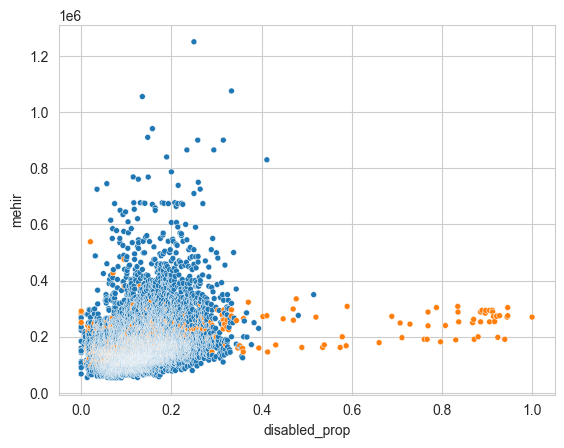

In [34]:
sns.scatterplot(data=bymodel, x='disabled_prop', y='mehir', size=3, legend=False, hue=bymodel['ppl_mover'])

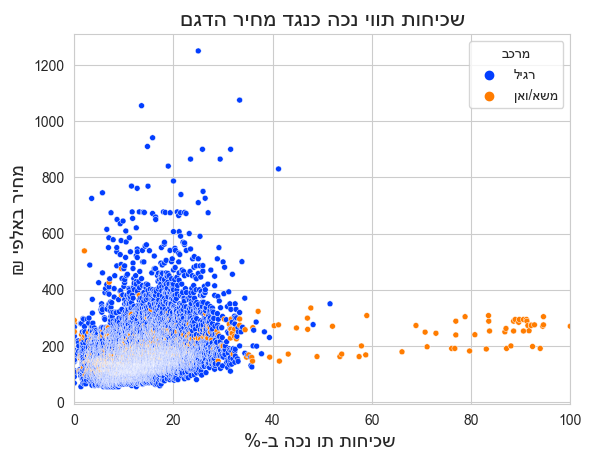

In [35]:
def rev(s):
    return s[::-1]

# Customize the plot style and aesthetics
sns.set_style("whitegrid")
sns.set_palette("bright")

#custom_palette = {"foo": sns.color_palette()[0], "bar": sns.color_palette()[1]}

bymodel['d_p'] = 100*bymodel['disabled_prop']
bymodel['mk'] = bymodel['mehir']/1000
#bymodel['ppl_mover'] = bymodel['ppl_mover'].astype(int)

ax = sns.scatterplot(data=bymodel, x='d_p', y='mk', size=4, hue=bymodel['ppl_mover'])

fs=14
plt.title(rev("שכיחות תווי נכה כנגד מחיר הדגם"), fontsize=fs+2)
plt.xlabel(rev(" שכיחות תו נכה ב-%"), fontsize=fs)
plt.ylabel(rev("מחיר באלפי ₪"), fontsize=fs)

plt.ticklabel_format(style='plain', axis='y')
plt.xlim(0, 100)

handles, labels = ax.get_legend_handles_labels()
handles = handles[:-1]
labels = labels[:-1]
ax.legend(title=rev("מרכב"), labels=[rev("רגיל"), rev("משא/ואן")], handles=handles)


In [36]:
models_ = read_file(datadir + 'models.csv', enc='utf-8')

/var/folders/l5/kkx8dwdn57s3v0k59p9m7sv80007gv/T/ipykernel_22615/907659671.py:3: DtypeWarning: Columns (16,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fd, sep='|')


In [37]:
models_.query('gova > 200 and hanaa_nm == "4X4" and nefah_manoa > 2000 and mispar_moshavim < 7')[['tozeret_nm','kinuy_mishari', 'mispar_moshavim']].drop_duplicates()

,tozeret_nm,kinuy_mishari,mispar_moshavim
136,דימלרקריזלר-גר,313 CDI,6
1002,גיפ-ישראל,סופה,4
2275,טויוטה יפן,לנד קרוזר_ארוך,0
3601,מרצדס בנץ גרמנ,SPRINTER,3
3635,מרצדס בנץ גרמנ,SPRINTER,2
5142,פולקסווגן גרמנ,TRANSPORTER,3
5166,פולקסווגן גרמנ,TRANSPORTER,2
5321,פולקסווגן גרמנ,TRNSPORTER,3
6898,פולקסווגן גרמנ,LT,1
6960,"פורד ארהב""",F 150,5
